# Stock selection and portfolio performance based on ESG Scores
by Chee-Foong on 11 Mar 2021

## Summary

This analysis studies the performance of portfolios constructed by selecting securities in the S&P 500 universe.  Stock selection are based on sectors and ESG scores.  The stocks in the portfolios are equally weighted and performance are compared with an equally weighted benchmark of all the securities in the S&P 500 universe.  

## Data

1. Yahoo Finance for financial information like prices, sectors and ESG scores
2. Datahub for list of securities in S&P 500

## Reference

1. https://datahub.io/core/s-and-p-500-companies#resource-constituents

---
## Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np

# pd.options.display.max_columns = 50
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

plt.rcParams.update({'figure.figsize':(15,3), 'figure.dpi':60})
plt.style.use('fivethirtyeight')

In [2]:
import sys  
sys.path.append('../src') 
from edge import *
from edge_risk_kit import *
import edge_risk_kit as erk

In [3]:
# Others
import requests
import io
import string
import re
from pprint import pprint
from tqdm.notebook import tqdm
import io

In [4]:
DATA_FOLDER = '../data/'
createfolder(DATA_FOLDER)

Load list of S&P 500 constituents tickers

In [5]:
snp = pd.read_csv(DATA_FOLDER + 'snp500_constituents.csv')

In [6]:
snp.set_index('Symbol', inplace=True)

In [7]:
snp.head()

,Name,Sector
Symbol,,
MMM,3M Company,Industrials
AOS,A.O. Smith Corp,Industrials
ABT,Abbott Laboratories,Health Care
ABBV,AbbVie Inc.,Health Care
ABMD,Abiomed,Health Care


## Data Extraction from Yahoo Finance
### ESG Scores

In [8]:
import yfinance as yf

May take a while to extract information for all securities

In [9]:
# Retrieve Yahoo! Finance Sustainability Scores for each ticker
esg_data = pd.DataFrame([])

for ticker in tqdm(snp.index):

    try:
#         print('Processing {}'.format(ticker))
        temp = yf.Ticker(ticker).sustainability.T
        temp['symbol'] = ticker
        
        esg_data = pd.concat([esg_data,temp])
        
    except Exception as e:
#         print(e)
        continue
        
esg_data.set_index('symbol', inplace=True)

  0%|          | 0/505 [00:00<?, ?it/s]

Selecting required columns and cleaning up data

In [10]:
required_cols = ['socialScore','governanceScore','environmentScore','totalEsg',
                 'esgPerformance','percentile','peerGroup','highestControversy']

esg_data.columns.name = ''
esg_data = esg_data[required_cols]
esg_data = esg_data.apply(pd.to_numeric, errors='ignore') 

In [11]:
esg_data.shape

(453, 8)

In [12]:
esg_data.sort_values('totalEsg', ascending=False).head()

,socialScore,governanceScore,environmentScore,totalEsg,esgPerformance,percentile,peerGroup,highestControversy
symbol,,,,,,,,
COG,15.58,9.83,24.58,49.98,LEAD_PERF,96.39,Oil & Gas Producers,2
LEG,17.19,11.17,20.38,48.74,None,95.68,Industrial Conglomerates,2
GE,15.72,11.49,15.44,42.65,None,89.12,Industrial Conglomerates,3
MRO,10.27,8.77,23.08,42.11,None,88.32,Oil & Gas Producers,2
PRGO,23.67,13.54,3.10,40.31,None,85.31,Pharmaceuticals,2


Save ESG Scores

In [13]:
esg_data.to_csv(DATA_FOLDER + 'esg_scores.csv')

---
### Security Reference

In [14]:
tickers = snp.index.to_list()

Extract Market Cap of all securities

In [15]:
tickerinfo = []
for ticker in tqdm(tickers):
    try:
        info = yf.Ticker(ticker).info
        info['symbol'] = ticker
        tickerinfo.append(info)
        
    except Exception as e:
        continue

  0%|          | 0/505 [00:00<?, ?it/s]

In [16]:
security_data = pd.DataFrame(tickerinfo)
security_data.set_index('symbol', inplace=True)

In [17]:
security_data.shape

(503, 125)

In [18]:
security_data.to_csv(DATA_FOLDER + 'security_data.csv')

---
### Prices

In [19]:
start_date = '2000-01-01'
end_date = '2021-12-31'

In [20]:
data = yf.download(tickers, start=start_date, end=end_date)

[*********************100%***********************]  505 of 505 completed

2 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No data found, symbol may be delisted


In [21]:
prices = data['Adj Close'][tickers]

In [22]:
px = prices.loc['2015':].dropna(axis=1, how='all')

In [23]:
px.to_csv(DATA_FOLDER + 'prices.csv')

In [24]:
px

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AAP,AMD,AES,AFL,A,APD,AKAM,ALK,ALB,ARE,ALXN,ALGN,ALLE,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AEE,AAL,AEP,AXP,AIG,AMT,AWK,AMP,ABC,AME,AMGN,APH,ADI,ANSS,ANTM,AON,APA,AAPL,AMAT,APTV,ADM,ANET,AJG,AIZ,T,ATO,ADSK,ADP,AZO,AVB,AVY,BKR,BLL,BAC,BAX,BDX,BBY,BIO,BIIB,BLK,BA,BKNG,BWA,BXP,BSX,BMY,AVGO,BR,CHRW,COG,CDNS,CPB,COF,CAH,KMX,CCL,CARR,CTLT,CAT,CBOE,CBRE,CDW,CE,CNC,CNP,CERN,CF,SCHW,CHTR,CVX,CMG,CB,CHD,CI,CINF,CTAS,CSCO,C,CFG,CTXS,CME,CMS,KO,CTSH,CL,CMCSA,CMA,CAG,COP,ED,STZ,CPRT,GLW,CTVA,COST,CCI,CSX,CMI,CVS,DHI,DHR,DRI,DVA,DE,DAL,XRAY,DVN,DXCM,FANG,DLR,DFS,DISCA,DISCK,DISH,DG,DLTR,D,DPZ,DOV,DOW,DTE,DUK,DRE,DD,DXC,EMN,ETN,EBAY,ECL,EIX,EW,EA,EMR,ENPH,ETR,EOG,EFX,EQIX,EQR,ESS,EL,ETSY,RE,EVRG,ES,EXC,EXPE,EXPD,EXR,XOM,FFIV,FB,FAST,FRT,FDX,FIS,FITB,FRC,FE,FISV,FLT,FLIR,FLS,FMC,F,FTNT,FTV,FBHS,FOXA,FOX,BEN,FCX,GPS,GRMN,IT,GD,GE,GIS,GM,GPC,GILD,GPN,GL,GS,GWW,HAL,HBI,HIG,HAS,HCA,PEAK,HSIC,HES,HPE,HLT,HFC,HOLX,HD,HON,HRL,HST,HWM,HPQ,HUM,HBAN,HII,IEX,IDXX,INFO,ITW,ILMN,INCY,IR,INTC,ICE,IBM,IFF,IP,IPG,INTU,ISRG,IVZ,IPGP,IQV,IRM,JBHT,JKHY,J,SJM,JNJ,JCI,JPM,JNPR,KSU,K,KEY,KEYS,KMB,KIM,KMI,KLAC,KHC,KR,LB,LHX,LH,LRCX,LW,LVS,LEG,LDOS,LEN,LLY,LNC,LIN,LYV,LKQ,LMT,L,LOW,LUMN,LYB,MTB,MRO,MPC,MKTX,MAR,MMC,MLM,MAS,MA,MXIM,MKC,MCD,MCK,MDT,MRK,MET,MTD,MGM,MCHP,MU,MSFT,MAA,MHK,TAP,MDLZ,MPWR,MNST,MCO,MS,MSI,MSCI,NDAQ,NTAP,NFLX,NWL,NEM,NWSA,NWS,NEE,NLSN,NKE,NI,NSC,NTRS,NOC,NLOK,NCLH,NOV,NRG,NUE,NVDA,NVR,ORLY,OXY,ODFL,OMC,OKE,ORCL,OTIS,PCAR,PKG,PH,PAYX,PAYC,PYPL,PNR,PBCT,PEP,PKI,PRGO,PFE,PM,PSX,PNW,PXD,PNC,POOL,PPG,PPL,PFG,PG,PGR,PLD,PRU,PEG,PSA,PHM,PVH,QRVO,QCOM,PWR,DGX,RL,RJF,RTX,O,REG,REGN,RF,RSG,RMD,RHI,ROK,ROL,ROP,ROST,RCL,SPGI,CRM,SBAC,SLB,STX,SEE,SRE,NOW,SHW,SPG,SWKS,SLG,SNA,SO,LUV,SWK,SBUX,STT,STE,SYK,SIVB,SYF,SNPS,SYY,TMUS,TROW,TTWO,TPR,TGT,TEL,TDY,TFX,TER,TSLA,TXN,TXT,BK,CLX,COO,HSY,MOS,TRV,DIS,TMO,TJX,TSCO,TT,TDG,TRMB,TFC,TWTR,TYL,TSN,USB,UDR,ULTA,UAA,UA,UNP,UAL,UPS,URI,UNH,UHS,UNM,VLO,VAR,VTR,VRSN,VRSK,VZ,VRTX,VFC,VIAC,VTRS,V,VNT,VNO,VMC,WRB,WBA,WMT,WM,WAT,WEC,WFC,WELL,WST,WDC,WU,WAB,WRK,WY,WHR,WMB,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02,137.071991,25.562347,39.701111,49.825306,37.310001,78.635353,19.261734,72.339996,155.756485,2.670000,10.774447,26.270859,38.341019,114.676270,63.250000,54.987873,54.367535,75.095619,186.600006,56.200001,52.137733,27.291727,61.989040,529.549988,523.373108,35.586044,308.519989,8.719368,37.806034,51.079918,49.229496,84.234779,48.292248,88.603989,47.451954,112.411827,81.501778,50.488506,135.283920,25.313435,48.195782,81.639999,114.563293,87.938614,55.793522,24.726921,22.620533,56.449505,42.993591,62.680000,39.949097,59.092979,23.715950,48.299152,59.529999,72.732758,616.789978,136.323929,45.590755,33.761242,32.043594,15.947729,36.558884,127.779503,32.133629,120.349998,342.010010,303.972839,112.786011,1142.060059,49.778084,109.830925,13.220000,50.372330,84.040421,40.852898,63.759365,28.082863,18.830000,36.503098,72.569275,66.228333,66.470001,38.649097,NaN,27.510000,74.855690,58.338226,34.669998,32.471039,52.716599,26.110001,18.231230,63.837994,43.924183,27.948614,166.429993,85.623070,678.400024,98.024376,36.110790,102.234550,42.860153,73.235611,22.780064,47.905178,20.606985,49.149902,69.596703,29.229811,34.617867,50.160130,59.734951,25.474699,38.759720,23.637255,57.289810,52.572819,90.316299,18.290001,19.623997,NaN,120.391144,63.563194,32.203411,121.908470,81.299774,23.185188,42.681057,43.876640,75.830002,77.562843,44.267326,49.771557,53.687138,54.509998,56.920700,52.302738,5

---
## Data Loading

In [25]:
esg_data = pd.read_csv(DATA_FOLDER + 'esg_scores.csv')
security_data = pd.read_csv(DATA_FOLDER + 'security_data.csv')
px = pd.read_csv(DATA_FOLDER + 'prices.csv')

In [26]:
esg_data.set_index('symbol', inplace=True)
security_data.set_index('symbol', inplace=True)
px.Date = pd.to_datetime(px.Date)
px.set_index('Date', inplace=True)

Remove securities that did not have enough price history

In [27]:
px = px[px.columns[px.count() == px.count().max()]]

## Analytics Calculation

In [28]:
def calcRetsCov(px, freq):
    px_freq = px.resample(freq).fillna('ffill')
    px_freq.index = px_freq.index.to_period(freq)

    rets = px_freq.pct_change().dropna(axis=1, how='all').dropna()
    cov = rets.cov()
    return rets, cov

rets_monthly, cov_monthly = calcRetsCov(px, 'M')
rets_period = rets_monthly
PERIODS_PER_YEAR = 12
RISK_FREE_RATE = 0.013
risk_data = erk.summary_stats(rets_period, riskfree_rate=RISK_FREE_RATE, periods_per_year=PERIODS_PER_YEAR).sort_values('Sharpe Ratio', ascending=False)

full_data = risk_data.join(esg_data).join(security_data['marketCap']).join(snp)
full_data = full_data[~full_data.totalEsg.isnull()]
full_data['mktcap_grp'] = pd.cut(full_data.percentile, 3, labels=["Small", "Medium", "Large"])

largePeerGroup = esg_data.peerGroup.value_counts().index[0:20].to_list()
full_data['peerGroup2'] = full_data.peerGroup.apply(lambda x: x if x in largePeerGroup else 'Others')

full_data['esg_soc_grp'] = pd.cut(full_data.socialScore, 5, labels=["Severe Risk", "High Risk", "Medium Risk", "Low Risk", "No Risk"])
full_data['esg_env_grp'] = pd.cut(full_data.environmentScore, 5, labels=["Severe Risk", "High Risk", "Medium Risk", "Low Risk", "No Risk"])
full_data['esg_gov_grp'] = pd.cut(full_data.governanceScore, 5, labels=["Severe Risk", "High Risk", "Medium Risk", "Low Risk", "No Risk"])
full_data['esg_tot_grp'] = pd.cut(full_data.totalEsg, 5, labels=["Severe Risk", "High Risk", "Medium Risk", "Low Risk", "No Risk"])

There are 2 columns classifying the securities to respective industry: Sector and peerGroup.  Sector comes from the security reference information downloaded from datahub and peerGroup from the ESG data downloaded from yahoo finance.  peerGroup data is more granular.  For analysis purpose, we will select the top 20 peerGroup with the most securities and the rest to be grouped under Others.  peerGroup2 column is created to store this data.

---
## Data Exploratory and Analytics

In [29]:
full_data.head()

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown,socialScore,governanceScore,environmentScore,totalEsg,esgPerformance,percentile,peerGroup,highestControversy,marketCap,Name,Sector,mktcap_grp,peerGroup2,esg_soc_grp,esg_env_grp,esg_gov_grp,esg_tot_grp
MSCI,0.408802,0.225988,-0.196780,3.015179,0.079098,0.112014,1.730956,-0.178912,16.71,5.83,0.11,22.65,NaN,30.18,Commercial Services,1.0,33840723968,MSCI Inc,Financials,Small,Commercial Services,Low Risk,Severe Risk,High Risk,High Risk
NVDA,0.732971,0.414673,-0.001473,3.802155,0.139946,0.226926,1.715941,-0.524469,4.15,6.88,2.33,13.37,LAG_PERF,4.83,Semiconductors,2.0,309212610560,Nvidia Corporation,Information Technology,Small,Semiconductors,Severe Risk,Severe Risk,High Risk,Severe Risk
MSFT,0.354296,0.204707,0.315138,3.392427,0.063450,0.080908,1.647726,-0.108081,9.37,4.90,0.47,14.74,LAG_PERF,7.55,Software & Services,3.0,1752962695168,Microsoft Corp.,Information Technology,Small,Software & Services,High Risk,Severe Risk,Severe Risk,Severe Risk
CDNS,0.396524,0.240104,0.405283,3.249293,0.074251,0.093939,1.578624,-0.180339,10.48,5.40,1.16,17.04,UNDER_PERF,12.51,Software & Services,0.0,35396222976,Cadence Design Systems,Information Technology,Small,Software & Services,Medium Risk,Severe Risk,Severe Risk,High Risk
ADBE,0.356476,0.216385,0.033103,2.497689,0.074483,0.089723,1.568750,-0.161919,5.65,4.74,0.48,10.88,UNDER_PERF,2.24,Software & Services,1.0,209470259200,Adobe Inc.,Information Technology,Small,Software & Services,Severe Risk,Severe Risk,Severe Risk,Severe Risk


In [30]:
full_data.shape

(448, 25)

There are 449 securities for selection for this analysis.

## Pair Scatter Plots of ESG Scores

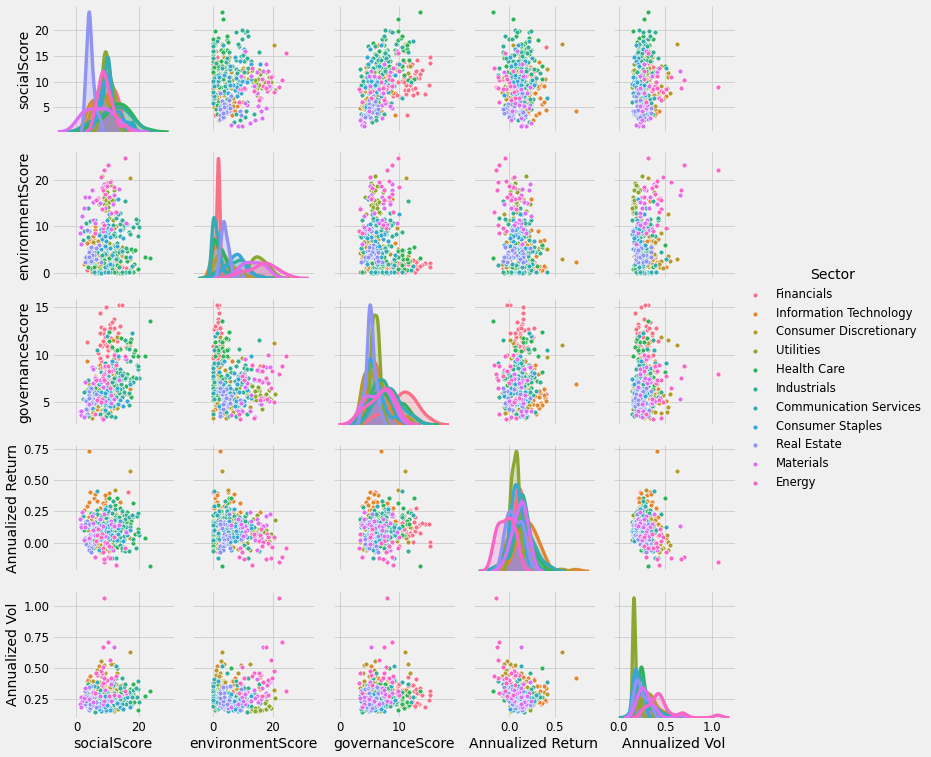

In [31]:
sns.pairplot(data = full_data[['socialScore','environmentScore','governanceScore',
                               'Annualized Return','Annualized Vol','Sector']], hue='Sector')
plt.show()

#### Observations
1. From this histograms, companies in Real Estate have rather low social, environment and goverance score.
2. Most companies have rather low environment score.  This is especially true of companies in Health Care, Industrial and Financials.  This could be a case that these companies are operating without much environmental concerns to address in the first place.
3. Note that companies in Materials and Energy have high environment scores.  These companies are likely to focus on addressing this concerns due to their nature of work.
4. All companies have some form of governance and hence there are no zero governance score.  However, many companies have low governance scores.  Possible that companies pay more attention to social and environment concerns that are more obvious to outsiders.  Governance scoring requires more information from insiders like staffs and suppliers.
5. It is rather obvious that Financial, Energy, Health Care sectors have highest governance, environment and social scores generating average annualised returns.  Similar observations can be found for annualised volatility, especially Financials and Health Care.

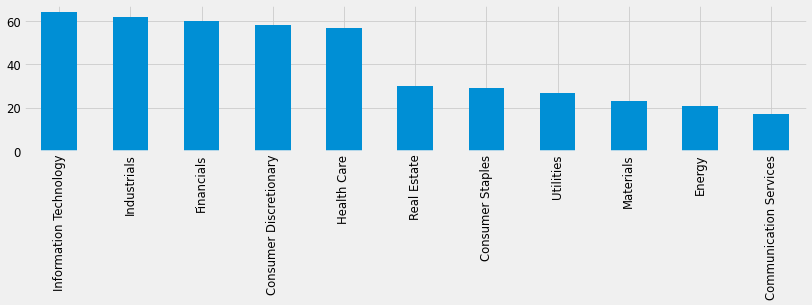

In [32]:
full_data.Sector.value_counts().plot.bar(figsize=(15,3))
plt.show()

In [33]:
print('5 sectors with most securities: {}'.format(', '.join(full_data.Sector.value_counts().head().index.to_list())))

5 sectors with most securities: Information Technology, Industrials, Financials, Consumer Discretionary, Health Care


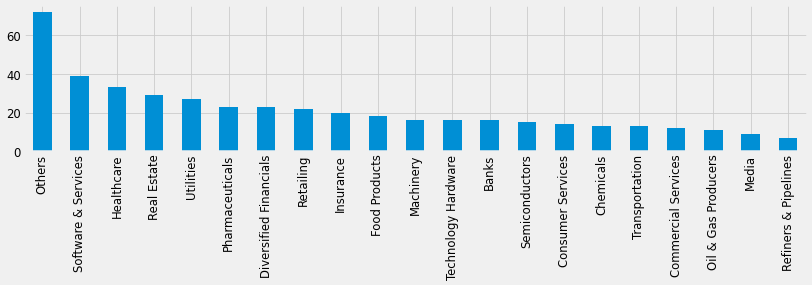

In [34]:
full_data.peerGroup2.value_counts().plot.bar(figsize=(15,3))
plt.show()

In [35]:
print('5 peerGroup with most securities: {}'.format(', '.join(full_data.peerGroup2.value_counts()[1:6].index.to_list())))

5 peerGroup with most securities: Software & Services, Healthcare, Real Estate, Utilities, Pharmaceuticals


It is good to keep in mind the number of data points in each Sectors and Peer Groups as we dissect the ESG below.

### Total ESG

In [36]:
def sorted_boxplot(data, x, y):
    grouped = data[[x,y]].groupby([x]).median().sort_values(y, ascending=False)
    ax = sns.boxplot(data=data, x=y, y=x, order=grouped.index, orient='h')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    plt.show()

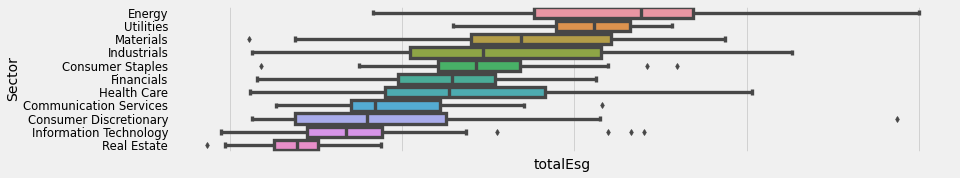

In [37]:
sorted_boxplot(full_data, 'Sector', 'totalEsg')

### Environment Score

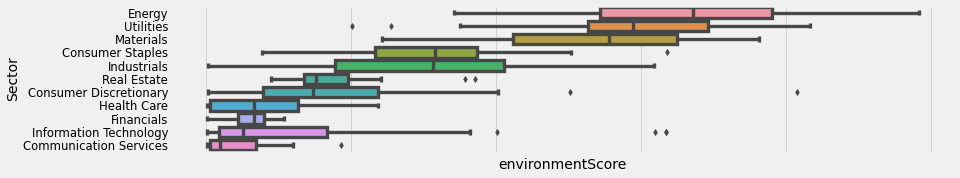

In [38]:
sorted_boxplot(full_data, 'Sector', 'environmentScore')

### Governance Score

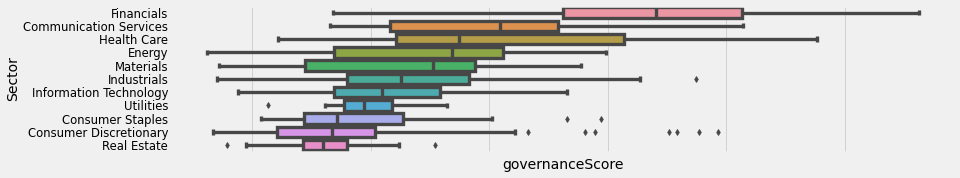

In [39]:
sorted_boxplot(full_data, 'Sector', 'governanceScore')

### Social Score

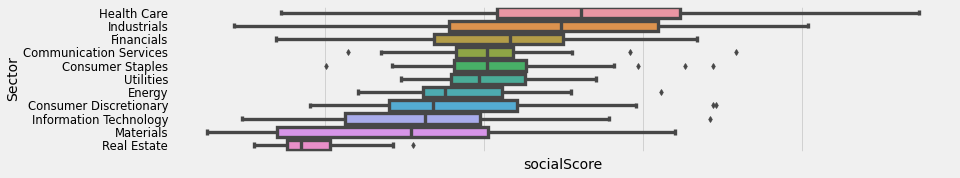

In [40]:
sorted_boxplot(full_data, 'Sector', 'socialScore')

#### Observations
1. Securities in energy-related sectors tends to have high environment ESG Score.  Relatively, they are higher than those securities with highest goverance and social ESG Score.  Hence, one can observe that the securities with high total ESG scores are from also from energy-related sectors.  The top 5 sectors with highest total ESG scores and the top 5 sectors with highest environement ESG scores are the same.
2. We can expect the performance of an equally weighted portfolio to be the same if we select the securities based on total ESG or environment ESG score.

---
## Portfolio Analysis

For this analysis, we create an equally weighted portfolio of all securities across all industries as our benchmark.  Performance of portfolios based on various security selection criterias are compared against this benchmark.  For consistency, each portfolio will only have 20 securities out of the total securities in the universe.

### Stock Selection 1
1. Sector = All
2. Number of portfolios = 4
3. Stock selection = Top 30 securities in terms of social, governance, environment, total ESG Score
4. Portfolio Names: 
    - socialScore
    - governanceScore
    - environmentScore
    - totalEsg

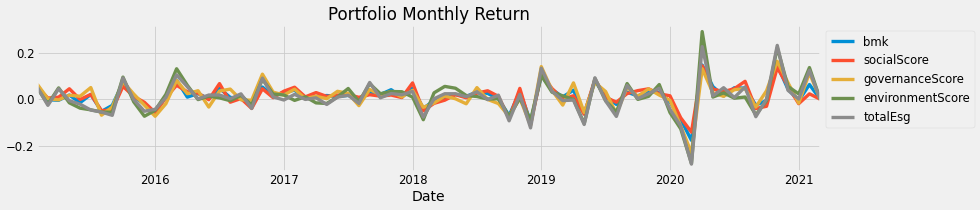

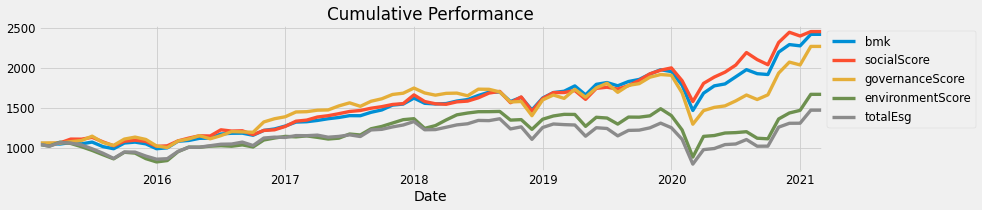

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
socialScore,0.156975,0.166182,-0.347831,4.639401,0.068037,0.103322,0.856127,-0.210088
bmk,0.154331,0.166467,-0.549625,6.386193,0.069249,0.107548,0.838963,-0.257026
governanceScore,0.142355,0.203627,-0.773325,6.471955,0.091215,0.133213,0.627687,-0.323298
environmentScore,0.087065,0.254066,0.223520,7.958182,0.098201,0.149402,0.287952,-0.404436
totalEsg,0.065100,0.245892,-0.188179,7.267672,0.105815,0.156547,0.209249,-0.414313


In [41]:
score_list = ['socialScore','governanceScore','environmentScore','totalEsg']
num_of_stocks = 30

## only need the expected return to generate the equal weights... other than that is redundant for now
er_bmk = erk.annualize_rets(rets_monthly, 12)
cov_bmk = rets_monthly.cov()

return_bmk = (ew(er_bmk) * rets_monthly).sum(axis=1)
wealth_bmk = erk.drawdown(return_bmk).Wealth 

return_port = {}
wealth_port = {}

return_port['bmk'] = return_bmk
wealth_port['bmk'] = wealth_bmk

for score in score_list:
    return_ = {}
    wealth_ = {}
    
    stock_selected = full_data.sort_values(score, ascending=False).head(num_of_stocks).index

    ## only need the expected return to generate the equal weights... other than that is redundant for now
    er_port = erk.annualize_rets(rets_monthly[stock_selected], 12)
    cov_port = rets_monthly[stock_selected].cov()
    
    return_ = (ew(er_port) * rets_monthly[stock_selected]).sum(axis=1)
    wealth_ = erk.drawdown(return_).Wealth 

    return_port[score] = return_
    wealth_port[score] = wealth_
    
return_port = pd.DataFrame(return_port)
wealth_port = pd.DataFrame(wealth_port)    

return_port.plot(title='Portfolio Monthly Return').legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

wealth_port.plot(title='Cumulative Performance').legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

erk.summary_stats(return_port, riskfree_rate=RISK_FREE_RATE, periods_per_year=PERIODS_PER_YEAR).sort_values('Sharpe Ratio', ascending=False)    

In [42]:
# full_data.loc[stock_selected.to_list()]

#### Observations
1. socialScore portfolio outperformed the benchmark.  This portfolio has the highest sharpe ratio at 0.856.
2. environmentScore and totalEsg portfolios' performances are poor.  totalEsg at the bottom with a sharp ratio of only 0.209.
3. Blinding selecting securities based on good totalEsg underperforms the benchmark significantly.
4. Good social Score securities come from good performing sectors (Health Care, Industrial, Financials) that outperforms the benchmark.

### Stock Selection 2

***Assuming you selected the top 3 outperforming sectors correctly***

1. Sector = 'Information Technology', 'Communication Services', 'Health Care'
2. Number of portfolios = 4
3. Stock selection = Top 30 securities in terms of social, governance, environment, total ESG Score
4. Portfolio Names: 
    - socialScore
    - governanceScore
    - environmentScore
    - totalEsg

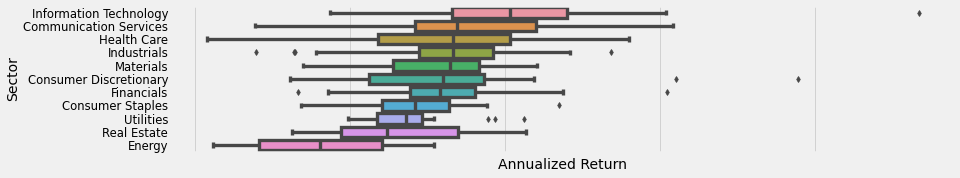

In [43]:
sorted_boxplot(full_data, 'Sector', 'Annualized Return')

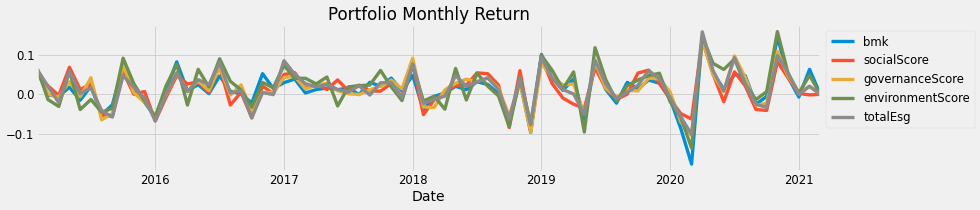

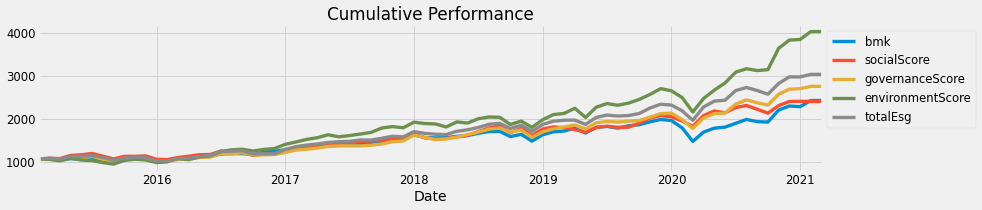

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
environmentScore,0.253394,0.184328,-0.148047,3.508552,0.068210,0.097127,1.288837,-0.202135
totalEsg,0.197019,0.155616,0.075368,3.786386,0.055641,0.077047,1.168610,-0.159839
governanceScore,0.178392,0.151920,-0.148630,3.809842,0.058042,0.083825,1.075851,-0.167231
socialScore,0.152639,0.149262,-0.114422,3.190490,0.058793,0.076332,0.924485,-0.119329
bmk,0.154331,0.166467,-0.549625,6.386193,0.069249,0.107548,0.838963,-0.257026


In [44]:
sector_list = ['Information Technology', 'Communication Services', 'Health Care']
score_list = ['socialScore','governanceScore','environmentScore','totalEsg']
num_of_stocks = 30

## only need the expected return to generate the equal weights... other than that is redundant for now
er_bmk = erk.annualize_rets(rets_monthly, 12)
cov_bmk = rets_monthly.cov()

return_bmk = (ew(er_bmk) * rets_monthly).sum(axis=1)
wealth_bmk = erk.drawdown(return_bmk).Wealth 

return_port = {}
wealth_port = {}

return_port['bmk'] = return_bmk
wealth_port['bmk'] = wealth_bmk

for score in score_list:
    return_ = {}
    wealth_ = {}
    
    stock_selected = full_data[full_data.Sector.isin(sector_list)].sort_values(score, ascending=False).head(num_of_stocks).index
    
    ## only need the expected return to generate the equal weights... other than that is redundant for now
    er_port = erk.annualize_rets(rets_monthly[stock_selected], 12)
    cov_port = rets_monthly[stock_selected].cov()
    
    return_ = (ew(er_port) * rets_monthly[stock_selected]).sum(axis=1)
    wealth_ = erk.drawdown(return_).Wealth 

    return_port[score] = return_
    wealth_port[score] = wealth_
    
return_port = pd.DataFrame(return_port)
wealth_port = pd.DataFrame(wealth_port)    

return_port.plot(title='Portfolio Monthly Return').legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

wealth_port.plot(title='Cumulative Performance').legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

erk.summary_stats(return_port, riskfree_rate=RISK_FREE_RATE, periods_per_year=PERIODS_PER_YEAR).sort_values('Sharpe Ratio', ascending=False)    

In [45]:
print('Stocks Selected: {}'.format(', '.join(full_data.loc[stock_selected.to_list()].Name.to_list())))

Stocks Selected: Perrigo, Universal Health Services, Stryker Corp., Zimmer Biomet, Microchip Technology, Skyworks Solutions, Danaher Corp., Qorvo, Facebook Inc., Boston Scientific, Lilly (Eli) & Co., Hologic, Johnson & Johnson, Abbott Laboratories, Intuitive Surgical Inc., AbbVie Inc., Teleflex, Becton Dickinson, Idexx Laboratories, Baxter International Inc., ResMed, DexCom, T-Mobile US, Varian Medical Systems, HCA Healthcare, Incyte, Broadcom Inc., Pfizer Inc., Twitter Inc., Vertex Pharmaceuticals Inc


#### Observations

1. It is quite expected that all the portfolios will outperforms the benchmark.
2. If sector picking is good, picking top 30 stocks with highest total ESG score will return a sharpe ratio of 1.18.
3. Note that even through companies in the Energy sectors tends to have high environment score and total ESG score, the portfolio performances are not due to these companies as Energy is not one of the select sectors to invest in. 


### Stock Selection 3

***Assuming you eliminated the top 3 underperforming sectors correctly***

1. Sector Excluded = 'Utilities', 'Real Estate', 'Energy'
2. Number of portfolios = 4
3. Stock selection = Top 30 securities in terms of social, governance, environment, total ESG Score
4. Portfolio Names: 
    - socialScore
    - governanceScore
    - environmentScore
    - totalEsg

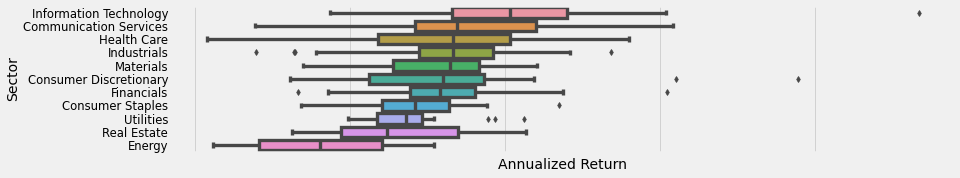

In [46]:
sorted_boxplot(full_data, 'Sector', 'Annualized Return')

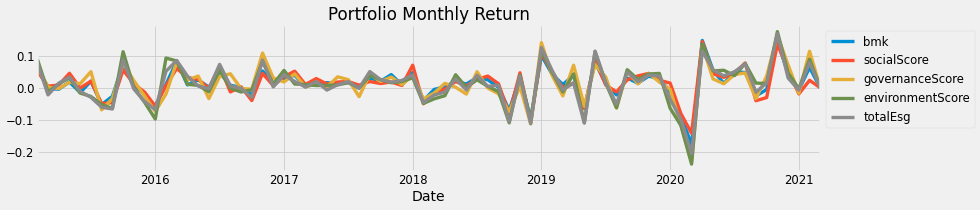

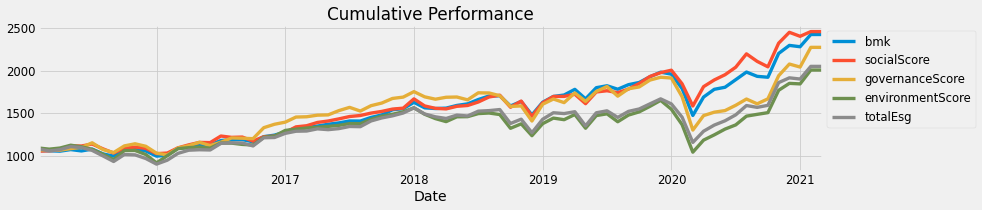

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
socialScore,0.156975,0.166182,-0.347831,4.639401,0.068037,0.103322,0.856127,-0.210088
bmk,0.154331,0.166467,-0.549625,6.386193,0.069249,0.107548,0.838963,-0.257026
governanceScore,0.142355,0.203627,-0.773325,6.471955,0.091215,0.133213,0.627687,-0.323298
totalEsg,0.123331,0.202954,-0.588782,5.021707,0.091237,0.132883,0.537131,-0.307138
environmentScore,0.119486,0.220046,-0.721624,5.495191,0.101425,0.143038,0.478117,-0.369221


In [47]:
sector_list = [s for s in list(set(full_data.Sector)) if s not in ['Utilities', 'Real Estate', 'Energy']]
score_list = ['socialScore','governanceScore','environmentScore','totalEsg']
num_of_stocks = 30

## only need the expected return to generate the equal weights... other than that is redundant for now
er_bmk = erk.annualize_rets(rets_monthly, 12)
cov_bmk = rets_monthly.cov()

return_bmk = (ew(er_bmk) * rets_monthly).sum(axis=1)
wealth_bmk = erk.drawdown(return_bmk).Wealth 

return_port = {}
wealth_port = {}

return_port['bmk'] = return_bmk
wealth_port['bmk'] = wealth_bmk

for score in score_list:
    return_ = {}
    wealth_ = {}
    
    stock_selected = full_data[full_data.Sector.isin(sector_list)].sort_values(score, ascending=False).head(num_of_stocks).index
    
    ## only need the expected return to generate the equal weights... other than that is redundant for now
    er_port = erk.annualize_rets(rets_monthly[stock_selected], 12)
    cov_port = rets_monthly[stock_selected].cov()
    
    return_ = (ew(er_port) * rets_monthly[stock_selected]).sum(axis=1)
    wealth_ = erk.drawdown(return_).Wealth 

    return_port[score] = return_
    wealth_port[score] = wealth_
    
return_port = pd.DataFrame(return_port)
wealth_port = pd.DataFrame(wealth_port)    

return_port.plot(title='Portfolio Monthly Return').legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

wealth_port.plot(title='Cumulative Performance').legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

erk.summary_stats(return_port, riskfree_rate=RISK_FREE_RATE, periods_per_year=PERIODS_PER_YEAR).sort_values('Sharpe Ratio', ascending=False)    

#### Observation
1.  The portfolio with the top Social score performs the best.  However, it only beats the benckmark slightly.
2.  There is no strong reason to believe the portfolio construction based on ESG scores alone will outperform the benchmark.

### Stock Selection 4

***A native sector selection based on observation from the pairs plot.  Financials and Health Care have high governance and social score with average annualised returns and volatility.***

1. Sector = 'Financials', 'Health Care'
2. Number of portfolios = 4
3. Stock selection = Top 30 securities in terms of social, governance, environment, total ESG Score
4. Portfolio Names: 
    - socialScore
    - governanceScore
    - environmentScore
    - totalEsg

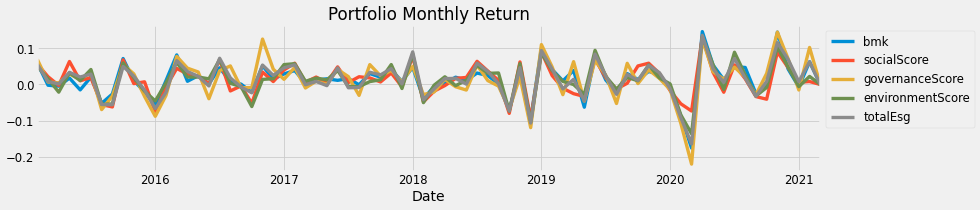

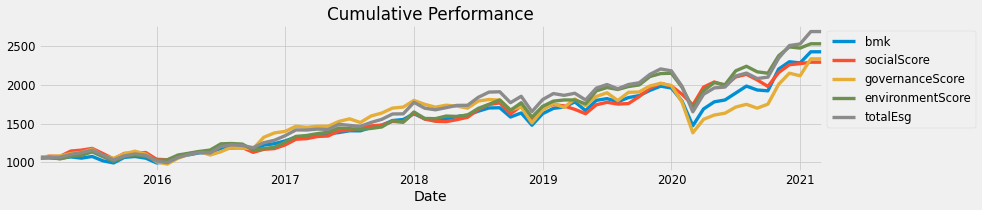

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
totalEsg,0.173564,0.171213,-0.691254,4.848941,0.073472,0.109518,0.926727,-0.250583
environmentScore,0.162159,0.161870,-0.451227,4.152380,0.067352,0.100020,0.910595,-0.209826
socialScore,0.143728,0.151453,-0.137043,3.156005,0.060775,0.081428,0.852962,-0.138255
bmk,0.154331,0.166467,-0.549625,6.386193,0.069249,0.107548,0.838963,-0.257026
governanceScore,0.147180,0.198347,-0.885341,6.039770,0.090355,0.134367,0.668445,-0.315283


In [48]:
sector_list = ['Financials', 'Health Care']
score_list = ['socialScore','governanceScore','environmentScore','totalEsg']
num_of_stocks = 30

## only need the expected return to generate the equal weights... other than that is redundant for now
er_bmk = erk.annualize_rets(rets_monthly, 12)
cov_bmk = rets_monthly.cov()

return_bmk = (ew(er_bmk) * rets_monthly).sum(axis=1)
wealth_bmk = erk.drawdown(return_bmk).Wealth 

return_port = {}
wealth_port = {}

return_port['bmk'] = return_bmk
wealth_port['bmk'] = wealth_bmk

for score in score_list:
    return_ = {}
    wealth_ = {}
    
    stock_selected = full_data[full_data.Sector.isin(sector_list)].sort_values(score, ascending=False).head(num_of_stocks).index
    
    ## only need the expected return to generate the equal weights... other than that is redundant for now
    er_port = erk.annualize_rets(rets_monthly[stock_selected], 12)
    cov_port = rets_monthly[stock_selected].cov()
    
    return_ = (ew(er_port) * rets_monthly[stock_selected]).sum(axis=1)
    wealth_ = erk.drawdown(return_).Wealth 

    return_port[score] = return_
    wealth_port[score] = wealth_
    
return_port = pd.DataFrame(return_port)
wealth_port = pd.DataFrame(wealth_port)    

return_port.plot(title='Portfolio Monthly Return').legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

wealth_port.plot(title='Cumulative Performance').legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

erk.summary_stats(return_port, riskfree_rate=RISK_FREE_RATE, periods_per_year=PERIODS_PER_YEAR).sort_values('Sharpe Ratio', ascending=False)    

#### Observation
1. Surprisingly, the portfolio with 30 stocks with the best total ESG score in the Financials and Health Care sectors performs well.  It returns a Sharpe Ratio of 0.926.  Slightly higher volatility then the benchmark but lower in maximum drawdown.
2. The portfolio constructed based on only the governance score is too volatile and has a much lower Sharpe Ratio then the benchmark.